Project Description

Objective: Use the GEDI L2B product to classify the San Pedro Riparian National Conservation Area (SPRNCA) by Foliage Height Diversity (FHD). 

FHD is an important metric for estimating ecological diversity and habitat suitability. Bird species are particularly sensitive in their habitat selection to vertical structure characteristics and the SPRNCA is an internationally recognized habitat zone for migratory and wintering birds. Zones would be classified using unsupervised techniques such as Agglomerative Clustering or DBSCAN. Once regions are classified,  I can evaluate present day trends in water stress over the different FHD classes to evaluate if parts of the corridor that are well suited for sensitive species habitat are particularly susceptible to water stress. To measure water stress, I will use either the ECOSTRESS Evaporative Stress Index (ESI) or EEflux’s METRIC based ET product coupled with ERA5’s PET estimate, depending on data availability. The primary outputs of this project will be maps classifying SPRNCA by FHD and time series plots and maps of the ESI for each FHD class.

The GEDI L2B product has an average spatial footprint of 25 meters and there are ~ 220 observations covering the SPRNCA corridor (I still need to determine how well this time series covers the SPRNCA). So this analysis would be limited to portions of the SPRNCA that have a riparian corridor wider than 25 meters. I also have near daily cloud masks from this area derived from Planet Labs imagery that I will use to filter the L2B and ESI products.

## Notes

GEDI data come in groups, and xarray can only read one at a time.

Quality FAQ with suggestions are here: https://lpdaac.usgs.gov/documents/589/GEDIL02_User_Guide_V1.pdf

conda install pyinterp -c conda-forge possible option for interpolation as it supports unstructured grids, 3D

this tweet has useful info on which beams use full power
https://twitter.com/GEDI_Knights/status/1228203192803966990

- BEAM0000 (ID 0) = Coverage
- BEAM0001 (ID 1) = Coverage
- BEAM0010 (ID 2) = Coverage
- BEAM0011 (ID 3) = Coverage
- BEAM0101 (ID 5) = Power
- BEAM0110 (ID 6) = Power
- BEAM1000 (ID 8) = Power
- BEAM1011 (ID 11) = Power

Interpretation of L2A Quality Flag
In order to provide end users with the ability to easily remove erroneous and/or
lower quality returns, we provide a quality_flag. This is a summation of several
individual quality assessment parameters and is intended to provide general
guidance only. A quality_flag value of 1 indicates the laser shot meets criteria
based on energy, sensitivity, amplitude, and real-time surface tracking quality.
Interpretation of L2B Quality Flag

In order to provide end users with the ability to easily remove erroneous and/or
lower quality returns, and returns not corresponding to the land surface, we
provide a quality_flag based on the outputs of the selected L2A algorithm
settings group. Results are available for every shot with a valid waveform, but
sometimes these results are not directly meaningful, such as vertical profile
metrics over the ocean.

As done for L2A, quality_flag is a summation of several individual quality
assessment parameters and other flags and is intended to provide general
guidance only. A quality_flag value of 1 indicates the cover and vertical profile
metrics represent the land surface and meet criteria based on waveform shot
energy, sensitivity, amplitude, and real-time surface track


In [1]:
#!bash gedi_to_vector.sh # for generating shp files from h5 files

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pygedi.clean_shps import *
import dask

In [2]:
shps = list(Path("data/processed").glob("GEDI*.shp"))

if Path("data/processed/all_samples_subsetted.gpkg").exists() == False:
    gdfs = []
    for path in shps:
        print(path)
        gdf = preprocess_gedi_gdf(path)

        gdfs.append(gdf)

    all_samples_df = pd.concat(gdfs)
    # weird, had to rename this to get it to save, maybe fid is reserved word for this format
    #all_samples_df.rename({"fid":"scan_id"}, axis=1).to_file("data/processed/all_samples.gpkg", driver="GPKG")
    all_samples_df['scan_id'] = all_samples_df.name.str[9:22]
    san_pedro = gpd.read_file("data/site_vectors/OSM_SanPedro.shp")

    # the SPRNCA bound file is about 8000m wide but not uniform so this is a uniform buffer at it's widest distance
    buffered_river_1000m = san_pedro.to_crs(32612).buffer(1000).to_crs(4326)

    all_samples_df.crs = buffered_river_1000m.crs # defines the crs of the GEDI samples as 4326

    intersects_riparian_mask = all_samples_df.intersects(buffered_river_1000m.unary_union)
    riparian_df = all_samples_df[intersects_riparian_mask]
    all_samples_df.to_file("data/processed/all_samples.gpkg", driver="GPKG")
    riparian_df.to_file("data/processed/all_samples_subsetted.gpkg", driver="GPKG")
else:
    riparian_df = gpd.read_file("data/processed/all_samples_subsetted.gpkg", index_col="delta_time")

san_pedro = gpd.read_file("data/site_vectors/OSM_SanPedro.shp")
san_pedro_riparian_corridor = gpd.read_file("data/site_vectors/SPRNCA_bound_wgs84.shp")
buffered_river_1000m = san_pedro.to_crs(32612).buffer(1000).to_crs(4326)
fth_wetlands = gpd.read_file("data/site_vectors/FtHua_wetlands.shp")

/home/rave/miniconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [3]:
mil_bounds = gpd.read_file("data/site_vectors/hua_military_boundaries.shp")
main_base = mil_bounds.explode()[mil_bounds.explode().area > .03] # gets the largest military boundary, near the san pedro
watershed = gpd.read_file("data/site_vectors/wbdhu6_spw.shp")
flow_perm = gpd.read_file("data/site_vectors/flow_permanence_SanPedro.shp")
hua_fields = gpd.read_file("data/site_vectors/huachuca_field_polys.shp")

We make a df with sample id duplicates dropped to only retain the geometry records and whole canopy metrics for faster plotting of those metrics and points.

In [4]:
riparian_df_with_z = riparian_df.copy()

riparian_df = riparian_df.drop_duplicates("sample_ind")

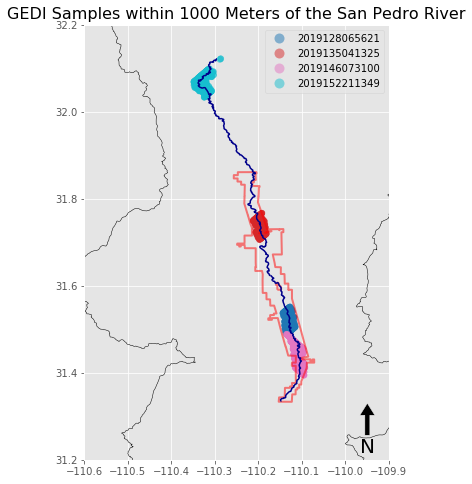

In [11]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(10,8))
riparian_df.plot(ax=ax, alpha=.5, column="scan_id", legend=True)
san_pedro.plot(ax=ax, color="darkblue", label = "San Pedro River")
san_pedro_riparian_corridor.plot(ax=ax, linewidth=2, facecolor="none", edgecolor = "red", alpha=.5, label= "SPRNCA Boundary")
# fth_wetlands.buffer(70).to_crs(4326).plot(ax=ax, color = "purple", label= "Fort Huachuca Wetlands")
watershed.plot(ax=ax, facecolor="none", edgecolor = "black", label= "Watershed Boundaries")
#main_base.plot(ax=ax, linewidth=2, facecolor="none", edgecolor = "orange", label= "Fort Huachuca Boundary")
plt.title("GEDI Samples within 1000 Meters of the San Pedro River", fontsize = 16)
ax.set_xlim(-110.6, -109.9)
ax.set_ylim(31.2, 32.2)
x, y, arrow_length = .93, .13, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
# plt.tight_layout()
plt.savefig("figs/SPRNCA_and_GEDI.png")

In [5]:
planet_1 = rx.open_rasterio("data/imagery/planet_gedi_sprnca1_clip1000m.tif", masked=True).astype("int16").transpose("y", "x", "band")
planet_2 = rx.open_rasterio("data/imagery/planet_gedi_sprnca2_clip1000m.tif", masked=True).astype("int16").transpose("y", "x", "band")
planet_3 = rx.open_rasterio("data/imagery/planet_gedi_sprnca3_clip1000m.tif", masked=True).astype("int16").transpose("y", "x", "band")

In [6]:
def evi2(NIR, Red):
    return 2.5*((NIR-Red)/(NIR+2.4*Red+1))

In [7]:
evi_planet1 = evi2(planet_1.sel(band=4), planet_1.sel(band=3))
evi_planet2 = evi2(planet_2.sel(band=4), planet_2.sel(band=3))
evi_planet3 = evi2(planet_3.sel(band=4), planet_3.sel(band=3))

In [8]:
evi_planet1.where(evi_planet1!=0).rio.to_raster("data/imagery/evi1.tif")
evi_planet2.where(evi_planet2!=0).rio.to_raster("data/imagery/evi2.tif")
evi_planet3.where(evi_planet3!=0).rio.to_raster("data/imagery/evi3.tif")

Need to use subset features from 95 and 75 evi thresholds to select points in dense cottonwoods and less dense cottonwoods/mesquite

In [30]:
riparian_df_utm = riparian_df.to_crs(32612)
san_pedro_utm = san_pedro.to_crs(32612)

In [31]:
riparian_df_utm["distance_to_channel"] = riparian_df_utm['geometry'].distance(san_pedro_utm['geometry'].unary_union)

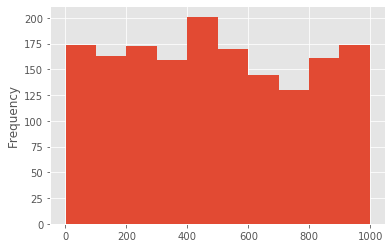

In [32]:
riparian_df_utm['distance_to_channel'].plot.hist()

Text(0.5, 1.0, 'Foliage Height Diversity Histogram for all points')

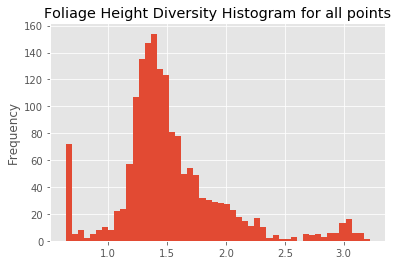

In [33]:
riparian_df_utm["fhd_normal"].plot.hist(bins=50)
plt.title("Foliage Height Diversity Histogram for all points")

Text(0.5, 1.0, 'Plant Area Index for all points')

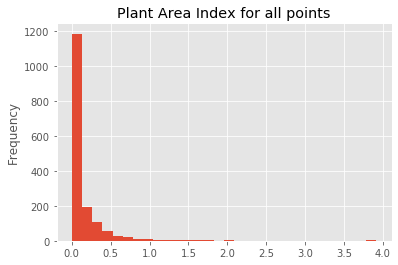

In [34]:
riparian_df_utm["pai"].plot.hist(bins=30)
plt.title("Plant Area Index for all points")

In [35]:
import altair as alt
alt.data_transformers.enable('json')
alt.Chart(riparian_df_utm).mark_point().encode(
    x='distance_to_channel',
    y='fhd_normal',
    color="scan_id"
)

alt.Chart(...)

In [36]:
brush = alt.selection(type='interval')
base = alt.Chart(riparian_df_utm).add_selection(brush)

# Configure the points
points = base.mark_point().encode(
    x=alt.X('distance_to_channel', title='Distance to Channel in Meters'),
    y=alt.Y('fhd_normal', title='Foliage Height Diversity (Shannon Entropy)'),
    color=alt.condition(brush, "scan_id", alt.value('grey'))
)

# Configure the ticks
tick_axis = alt.Axis(labels=False, domain=False, ticks=False)

x_ticks = base.mark_tick().encode(
    alt.X('distance_to_channel', axis=tick_axis),
    alt.Y("scan_id", title='', axis=tick_axis),
    color=alt.condition(brush, "scan_id", alt.value('lightgrey'))
)

y_ticks = base.mark_tick().encode(
    alt.X("scan_id", title='', axis=tick_axis),
    alt.Y('fhd_normal', axis=tick_axis),
    color=alt.condition(brush, "scan_id", alt.value('lightgrey'))
)

# Build the chart
y_ticks | (points & x_ticks)

alt.HConcatChart(...)

In [37]:
brush = alt.selection(type='interval')
base = alt.Chart(riparian_df_utm).add_selection(brush)

# Configure the points
points = base.mark_point().encode(
    x=alt.X('distance_to_channel', title='Distance to Channel in Meters'),
    y=alt.Y('pai', title='Plant Area Index'),
    color=alt.condition(brush, "scan_id", alt.value('grey'))
)

# Configure the ticks
tick_axis = alt.Axis(labels=False, domain=False, ticks=False)

x_ticks = base.mark_tick().encode(
    alt.X('distance_to_channel', axis=tick_axis),
    alt.Y("scan_id", title='', axis=tick_axis),
    color=alt.condition(brush, "scan_id", alt.value('lightgrey'))
)

y_ticks = base.mark_tick().encode(
    alt.X("scan_id", title='', axis=tick_axis),
    alt.Y('pai', axis=tick_axis),
    color=alt.condition(brush, "scan_id", alt.value('lightgrey'))
)

# Build the chart
x = y_ticks | (points & x_ticks)

In [38]:
x

alt.HConcatChart(...)

In [40]:
riparian_df_utm

,delta_time,fhd_normal,pai,cover,digital_el,landsat_tr,modis_tree,modis_tr_1,l2a_qualit,l2b_qualit,...,rx_sample_,longitude,latitude,BEAM,name,is_power_beam,is_sundown,scan_id,geometry,distance_to_channel
2012,2019-05-14T21:47:02,1.550733,0.027186,0.013501,1157.090454,0.0,0.0,4.70,1,1,...,58,-110.211901,31.749421,BEAM0000,GEDI02_B_2019135041325_O02381_T00292_02_001_01...,False,False,2019135041325,POINT (574642.914 3512931.562),956.803054
2013,2019-05-14T21:47:02,1.379416,0.084308,0.041277,1154.168091,0.0,0.0,4.70,1,1,...,58,-110.211479,31.749791,BEAM0000,GEDI02_B_2019135041325_O02381_T00292_02_001_01...,False,False,2019135041325,POINT (574682.669 3512972.892),902.361544
2014,2019-05-14T21:47:02,0.959952,0.012850,0.006405,1155.539307,0.0,1.0,3.44,1,1,...,56,-110.211056,31.750161,BEAM0000,GEDI02_B_2019135041325_O02381_T00292_02_001_01...,False,False,2019135041325,POINT (574722.426 3513014.209),848.306296
2015,2019-05-14T21:47:02,1.471633,0.025874,0.012853,1153.402100,0.0,1.0,3.44,1,1,...,57,-110.210633,31.750531,BEAM0000,GEDI02_B_2019135041325_O02381_T00292_02_001_01...,False,False,2019135041325,POINT (574762.184 3513055.500),794.722599
2016,2019-05-14T21:47:02,1.294599,0.066155,0.032536,1153.564819,0.0,2.0,6.80,1,1,...,55,-110.210210,31.750901,BEAM0000,GEDI02_B_2019135041325_O02381_T00292_02_001_01...,False,False,2019135041325,POINT (574801.968 3513096.810),741.665855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186261,2019-05-26T01:29:32,1.230891,0.024988,0.012416,1265.778687,0.0,2.0,4.41,1,1,...,66,-110.096025,31.395819,BEAM1011,GEDI02_B_2019146073100_O02554_T01521_02_001_01...,True,False,2019146073100,POINT (585942.079 3473823.208),799.478907
186262,2019-05-26T01:29:32,1.404599,0.106149,0.051690,1265.778687,0.0,2.0,4.41,1,1,...,69,-110.095605,31.395452,BEAM1011,GEDI02_B_2019146073100_O02554_T01521_02_001_01...,True,False,2019146073100,POINT (585982.279 3473782.773),846.177850
186263,2019-05-26T01:29:32,1.251902,0.031772,0.015761,1264.342285,0.0,2.0,4.41,1,1,...,65,-110.095186,31.395084,BEAM1011,GEDI02_B_2019146073100_O02554_T01521_02_001_01...,True,False,2019146073100,POINT (586022.475 3473742.338),894.070250
186264,2019-05-26T01:29:32,2.297677,0.575439,0.250014,1264.342285,0.0,2.0,4.41,1,1,...,117,-110.094767,31.394716,BEAM1011,GEDI02_B_2019146073100_O02554_T01521_02_001_01...,True,False,2019146073100,POINT (586062.670 3473701.898),942.977898


In [39]:
import altair as alt

brush = alt.selection(type='interval')

points = alt.Chart(riparian_df_utm).mark_point().encode(
    x='distance_to_channel',
    y='fhd_normal',
    color=alt.condition(brush, 'scan_id', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(riparian_df_utm).mark_bar().encode(
    y='scan_id',
    color='scan_id',
    x='count(scan_id)'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

### Finding nearest point on line to each sample, WIP. For distance along channel

In [189]:
from shapely.geometry import Point, Polygon
from shapely.ops import linemerge
from math import sqrt

# pairs iterator:
# http://stackoverflow.com/questions/1257413/1257446#1257446
def pairs(lst):
    i = iter(lst)
    first = prev = next(i)
    for item in i:
        yield prev, item
        prev = item
    yield item, first

# these methods rewritten from the C version of Paul Bourke's
# geometry computations:
# http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/
def magnitude(p1, p2):
    vect_x = p2.x - p1.x
    vect_y = p2.y - p1.y
    return sqrt(vect_x**2 + vect_y**2)

def intersect_point_to_line(point, line_start, line_end):
    line_magnitude =  magnitude(line_end, line_start)
    u = ((point.x - line_start.x) * (line_end.x - line_start.x) +
         (point.y - line_start.y) * (line_end.y - line_start.y)) \
         / (line_magnitude ** 2)

    # closest point does not fall within the line segment, 
    # take the shorter distance to an endpoint
    if u < 0.00001 or u > 1:
        ix = magnitude(point, line_start)
        iy = magnitude(point, line_end)
        if ix > iy:
            return line_end
        else:
            return line_start
    else:
        ix = line_start.x + u * (line_end.x - line_start.x)
        iy = line_start.y + u * (line_end.y - line_start.y)
        return Point([ix, iy])

nearest_point = None
min_dist = float("inf")

for seg_start, seg_end in pairs(list(linemerge(san_pedro_utm['geometry'].unary_union).coords)[:-1]):
    line_start = Point(seg_start)
    line_end = Point(seg_end)

    intersection_point = intersect_point_to_line(point, line_start, line_end)
    cur_dist =  magnitude(point, intersection_point)

    if cur_dist < min_dist:
        min_dist = cur_dist
        nearest_point = intersection_point

print("Closest point found at: %s, with a distance of %.2f units." % \
   (nearest_point, min_dist))

Closest point found at: POINT (574316.249437192 3507341.019329689), with a distance of 6187.76 units.


The above value differs from the distance value provided by geopandas by about 1000 meters... need to calcualte this myself but need the nearest point first. might need to super densely sample points along the line to get the nearest point and then use that to measure the distance?

In [196]:
from shapely.ops import linemerge
linemerge(san_pedro_utm['geometry'].unary_union).coords[:-1]

1587

### exploring gedi as xarrays

In [2]:
h5s = list(Path("data/GEDI_L2B_raw/").glob("*.h5"))

In [10]:
beam_groups = ["/BEAM0000", "/BEAM1011", "/BEAM1000", "/BEAM0110", "/BEAM0101", "/BEAM0011", "/BEAM0010", "/BEAM0001"]
beam_sub_groups = ["ancillary", "geolocation", "land_cover_data", "rx_processing"]
meta_group = "METADATA/DatasetIdentification"

In [11]:
def open_beams(file_path, beam_groups = ["/BEAM0000", "/BEAM1011", "/BEAM1000", "/BEAM0110", "/BEAM0101", "/BEAM0011", "/BEAM0010", "/BEAM0001"]):
    datasets = []
    for beam in beam_groups:
        print(beam)
        # coord related values that need to be assigned to the dataset.
        ds_geo = xr.open_dataset(file_path, group=f"/{beam}/geolocation/")
        lat_coords = ds_geo.lat_highestreturn.values
        lon_coords = ds_geo.lon_highestreturn.values
        time_coords = ds_geo.delta_time.values
        
        # renaming and prooer meter units for z, vertical profile
        dz = xr.open_dataset(file_path, group=f"/{beam}/ancillary").dz.values
        ds = xr.open_dataset(file_path, group=beam)
        dim_names = list(ds.dims)
        ds = ds.rename({dim_names[1]:"z"}).drop_dims(dim_names[2]) # phony 6 only used for directional gap prob profile. 
        ds['z'] = ds.z * dz # make z have units in meters
        
        # assigning location and time coords to the variables depending on if they represent avg over profile or are taken along profile
        ds = ds.rename({dim_names[0]:"y"})
        ds['y'] = lat_coords
        ds = ds.assign({"x":lon_coords, "time":time_coords})
        
        datasets.append(ds)
    return datasets

In [13]:
file_paths = list(Path("data").glob("*.h5"))

In [54]:
len(xr.open_dataset(file_paths[14], group="/BEAM1011/geolocation").coords['delta_time'].values)

410254

In [ ]:
list(xr.open_dataset(file_paths[0], group="/BEAM1011").dims)

In [ ]:
open_beams(file_paths[0])

In [36]:
shps[0]

PosixPath('data/GEDI02_B_2019125153619_O02233_T05438_02_001_01.shp')

In [51]:
file_paths[14]

PosixPath('data/GEDI02_B_2019125153619_O02233_T05438_02_001_01.h5')

In [ ]:
test_beam.sensitivity
test_beam.fhd_normal
test_beam.l2a_quality_flag
test_beam.l2b_quality_flag
test_beam.pai
test_beam.pai_z
test_beam.pavd_z
test_beam.l2b_quality_flag

In [ ]:
ds = xr.Dataset({'pai_z': (['x', 'y', 'time', 'z'],  test_beam.pai_z),
                 coords={'x': (['x', 'y'], lon_coords),
                         'y': (['x', 'y'], lat_coords),
                         'time': time_coords,
                        "z": test_beam.phony_dim_5.values}})